In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

#Statistics
# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# READ CSV AND DESCRIPTION OF SERIES


In [2]:
#HASH RATE
hash_rate = pd.read_csv("data/bitcoin-mean-hash-rate.csv")

hash_rate["Hash Rate/t"] = hash_rate["Hash Rate/t"].str.rstrip("T00:00:00.000Z")
hash_rate["Hash Rate/t"] = pd.to_datetime(hash_rate["Hash Rate/t"])
hash_rate = hash_rate.sort_values(by='Hash Rate/t')
hash_rate = hash_rate.rename(columns={'Hash Rate/t': 'Timestamp', 'Hash Rate/v': 'Value'})

################ RIMUOVO DATE 2009 E 2022
hash_rate = hash_rate[~(hash_rate['Timestamp'] < '2010-01-01')]
hash_rate = hash_rate[~(hash_rate['Timestamp'] > '2021-12-31')]

#fixing index
hash_rate.reset_index(drop=True, inplace=True)


#Description
print(hash_rate)
print("\nShape is:", hash_rate.shape)
print("\nSummary of the dataset:")
hash_rate.describe()
print("\nAre there null values?")
hash_rate.isna().sum()

      Timestamp         Value
0    2010-01-01  5.948447e+06
1    2010-01-01  1.116364e+07
2    2010-01-02  5.272979e+06
3    2010-01-02  1.015796e+07
4    2010-01-03  1.091864e+07
...         ...           ...
4378 2021-12-26  1.614002e+20
4379 2021-12-27  1.788373e+20
4380 2021-12-28  1.613201e+20
4381 2021-12-29  1.749405e+20
4382 2021-12-31  1.791817e+20

[4383 rows x 2 columns]

Shape is: (4383, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Value        0
dtype: int64

In [3]:
# Extract years
hash_rate['year'] = [d.year for d in hash_rate["Timestamp"]]

In [4]:
hash_rate.year.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021])

In [5]:
hash_rate.year.value_counts()

2012    366
2016    366
2020    366
2010    365
2011    365
2013    365
2014    365
2015    365
2017    365
2018    365
2019    365
2021    365
Name: year, dtype: int64

In [6]:
#vediamo che i primi 3 giorni hanno 2 date, quindi faccio la media
hash_rate.head(20)

,Timestamp,Value,year
0,2010-01-01,5.948447e+06,2010
1,2010-01-01,1.116364e+07,2010
2,2010-01-02,5.272979e+06,2010
3,2010-01-02,1.015796e+07,2010
4,2010-01-03,1.091864e+07,2010
5,2010-01-03,1.407738e+07,2010
6,2010-01-04,1.062697e+07,2010
7,2010-01-05,1.160149e+07,2010
8,2010-01-06,9.594317e+06,2010
9,2010-01-07,9.061630e+06,2010


In [7]:
hashvalue0=(hash_rate["Value"].iloc[0] + hash_rate["Value"].iloc[1])/2
hashvalue1=(hash_rate["Value"].iloc[2] + hash_rate["Value"].iloc[3])/2
hashvalue2=(hash_rate["Value"].iloc[4] + hash_rate["Value"].iloc[5])/2

print(hashvalue0, hashvalue1, hashvalue2)

8556044.78617744 7715467.699486125 12498012.0103342


In [8]:
hash_rate = hash_rate.drop(labels=0, axis=0)
hash_rate = hash_rate.drop(labels=2, axis=0)
hash_rate = hash_rate.drop(labels=4, axis=0)

#fixing index
hash_rate.reset_index(drop=True, inplace=True)

In [9]:
hash_rate

,Timestamp,Value,year
0,2010-01-01,1.116364e+07,2010
1,2010-01-02,1.015796e+07,2010
2,2010-01-03,1.407738e+07,2010
3,2010-01-04,1.062697e+07,2010
4,2010-01-05,1.160149e+07,2010
...,...,...,...
4375,2021-12-26,1.614002e+20,2021
4376,2021-12-27,1.788373e+20,2021
4377,2021-12-28,1.613201e+20,2021
4378,2021-12-29,1.749405e+20,2021


In [10]:
hash_rate["Value"].iloc[0] = hashvalue0
hash_rate["Value"].iloc[1] = hashvalue1
hash_rate["Value"].iloc[2] = hashvalue2

<ipython-input-10-db3f2db4d295>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hash_rate["Value"].iloc[0] = hashvalue0
<ipython-input-10-db3f2db4d295>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hash_rate["Value"].iloc[1] = hashvalue1
<ipython-input-10-db3f2db4d295>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hash_rate["Value"].iloc[2] = hashvalue2


In [11]:
hash_rate

,Timestamp,Value,year
0,2010-01-01,8.556045e+06,2010
1,2010-01-02,7.715468e+06,2010
2,2010-01-03,1.249801e+07,2010
3,2010-01-04,1.062697e+07,2010
4,2010-01-05,1.160149e+07,2010
...,...,...,...
4375,2021-12-26,1.614002e+20,2021
4376,2021-12-27,1.788373e+20,2021
4377,2021-12-28,1.613201e+20,2021
4378,2021-12-29,1.749405e+20,2021


# VISUALIZATION

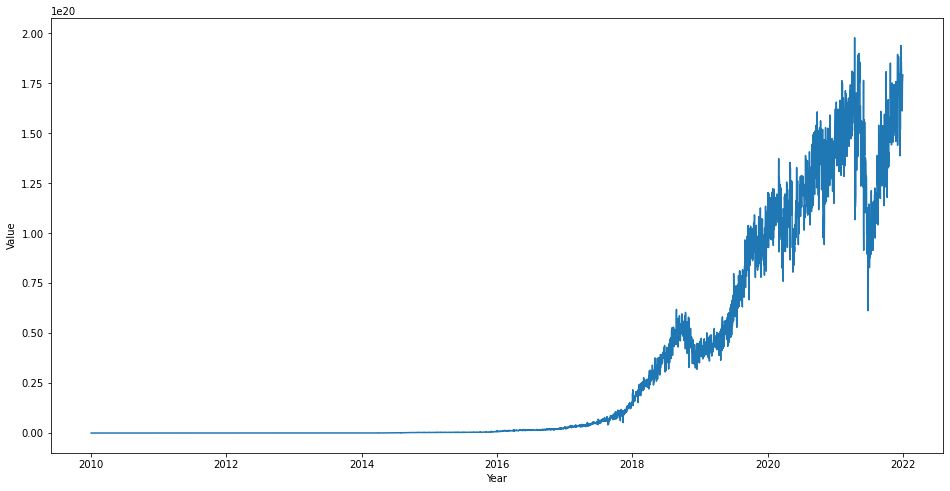

In [12]:
plt.figure(figsize=(16,8))
plt.plot(hash_rate["Timestamp"], hash_rate["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


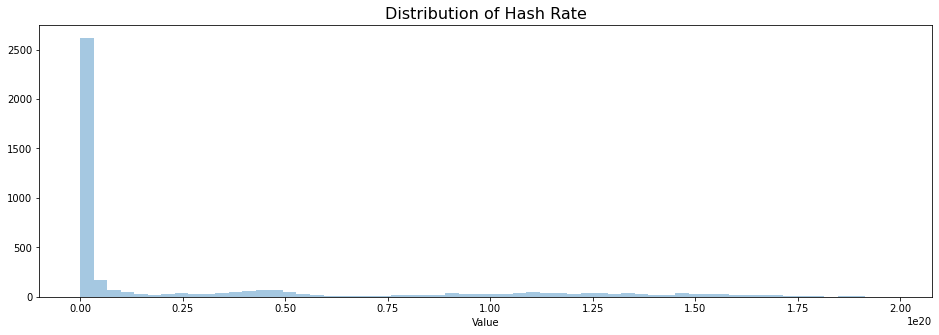

In [13]:
plt.figure(figsize=(16,5))
sns.distplot(hash_rate["Value"], kde = False, bins = 60)
plt.title('Distribution of Hash Rate', fontsize=16)
plt.show()

In [14]:
hash_rate_market = hash_rate
hash_rate_market = hash_rate[~(hash_rate['Timestamp'] < '2010-08-01')]
hash_rate_market

,Timestamp,Value,year
209,2010-08-01,3.349078e+09,2010
210,2010-08-01,2.898887e+09,2010
211,2010-08-02,4.912954e+09,2010
212,2010-08-02,2.906837e+09,2010
213,2010-08-03,4.607296e+09,2010
...,...,...,...
4375,2021-12-26,1.614002e+20,2021
4376,2021-12-27,1.788373e+20,2021
4377,2021-12-28,1.613201e+20,2021
4378,2021-12-29,1.749405e+20,2021


<IPython.core.display.Javascript object>


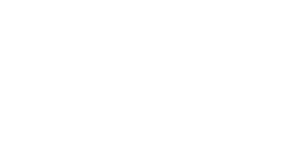

In [15]:
%matplotlib notebook
#MARKET PRICE
market_price = pd.read_csv("data/market-price.csv")

market_price['Timestamp'] = market_price['Timestamp'].str.split(' ').str[0]
market_price["Timestamp"] = pd.to_datetime(market_price["Timestamp"])
market_price = market_price.rename(columns={'market-price': 'Price'})

################ RIMUOVO DATE 2009 E 2022
market_price = market_price[~(market_price['Timestamp'] < '2009-01-01')]
market_price = market_price[~(market_price['Timestamp'] > '2021-12-31')]


fig, ax1 = plt.subplots(figsize=(16,8))

color = 'tab:red'
ax1.set_xlabel('Years')
ax1.set_ylabel('Hash Rate', color=color)
ax1.plot(hash_rate_market["Timestamp"], hash_rate_market["Value"], color=color, label='Hash Rate')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('BTC Price', color=color)  # we already handled the x-label with ax1
ax2.plot(market_price["Timestamp"], market_price["Price"], color=color, label='BTC Price')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

fig.legend(loc="upper left")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

%matplotlib inline

#### Shorter time series
Same as market price

In [16]:
hash_rate["Value"][hash_rate["Timestamp"].dt.year == 2014].mean()
hashh = hash_rate.loc[(hash_rate["Timestamp"].dt.year > 2016) & (hash_rate["Timestamp"].dt.year < 2022),:]
hashn = hash_rate.loc[(hash_rate["Timestamp"].dt.year > 2016) & (hash_rate["Timestamp"].dt.year < 2021),:]
hashnh = hash_rate.loc[(hash_rate["Timestamp"].dt.year > 2012) & (hash_rate["Timestamp"].dt.year < 2021),:]
hashf = hash_rate.loc[(hash_rate["Timestamp"].dt.year > 2012) & (hash_rate["Timestamp"].dt.year < 2022),:]

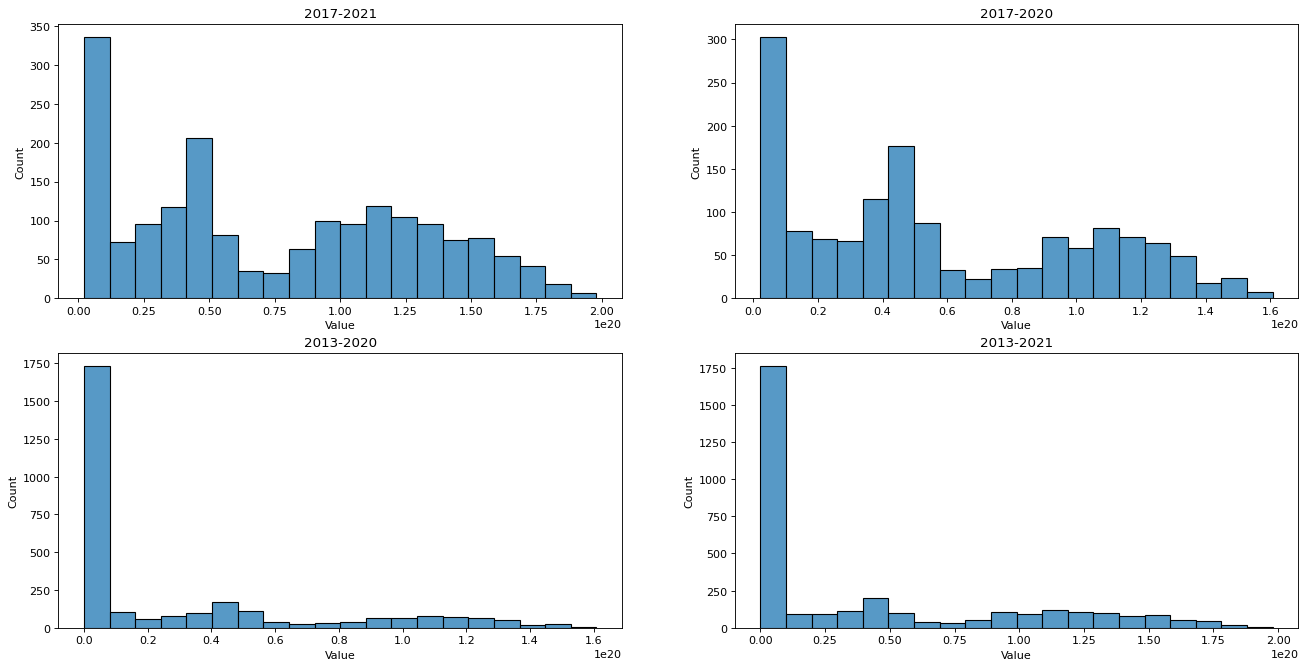

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.histplot(hashh["Value"], ax=axes[0,0],bins = 20)
sns.histplot(hashn["Value"], ax=axes[0,1],bins = 20)
sns.histplot(hashnh["Value"], ax=axes[1,0],bins = 20)
sns.histplot(hashf["Value"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

#### Checking monthly seasonality using multiple lines
Price follows a certain repetitive pattern every year? 

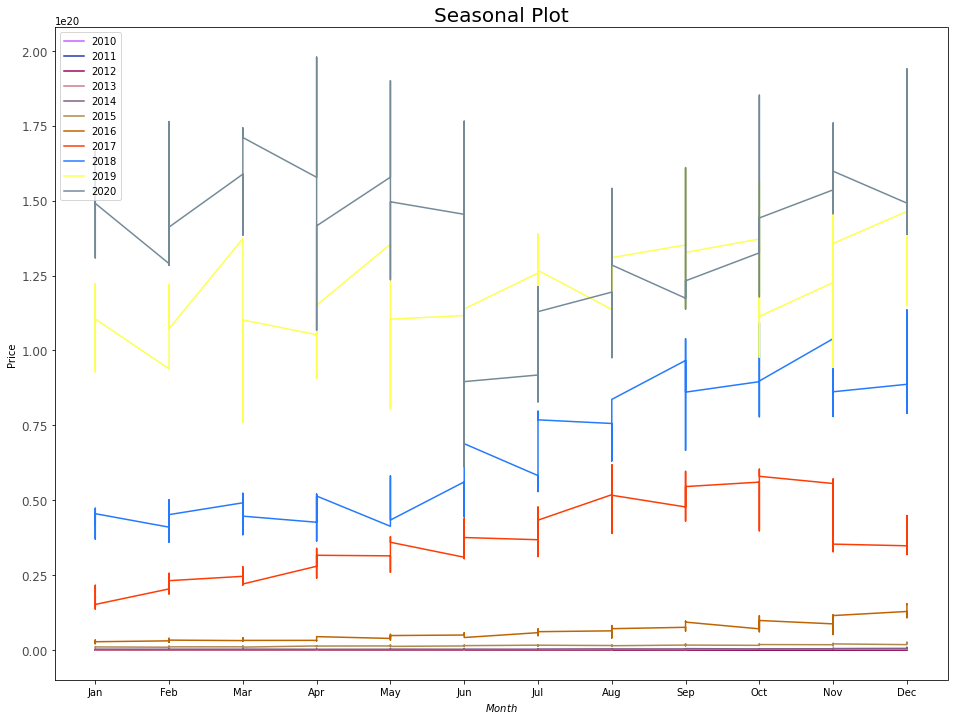

In [18]:
# Prepare data
hash_rate['year'] = [d.year for d in hash_rate["Timestamp"]]
hash_rate['month'] = [d.strftime('%b') for d in hash_rate["Timestamp"]]
years = hash_rate['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(matplotlib.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12))
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', "Value", data=hash_rate.loc[hash_rate.year==y, :], color=mycolors[i], label=y)
        #plt.text(market_price.loc[market_price.year==y, :].shape[0]-.9, market_price.loc[market_price.year==y, "Price"][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(ylabel= "Price", xlabel = '$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot", fontsize=20)
plt.legend(years, loc='upper left')
plt.show()

#### Checking trend using boxplot
Price follows a yearly trend or monthly seasonality? 

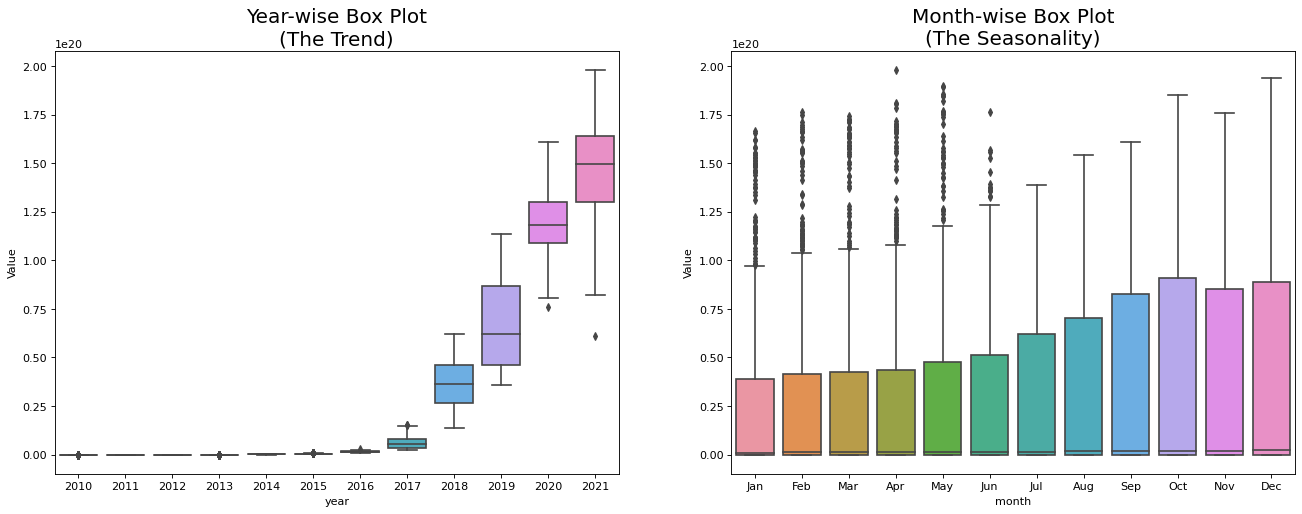

In [19]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y="Value", data=hash_rate, ax=axes[0])
sns.boxplot(x='month', y="Value", data=hash_rate.loc[~hash_rate.year.isin([2010, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [20]:
hash_rate["Value"]

0       8.556045e+06
1       7.715468e+06
2       1.249801e+07
3       1.062697e+07
4       1.160149e+07
            ...     
4375    1.614002e+20
4376    1.788373e+20
4377    1.613201e+20
4378    1.749405e+20
4379    1.791817e+20
Name: Value, Length: 4380, dtype: float64

Text(0.5, 0.98, 'HASH RATE / 2010-2021 ')

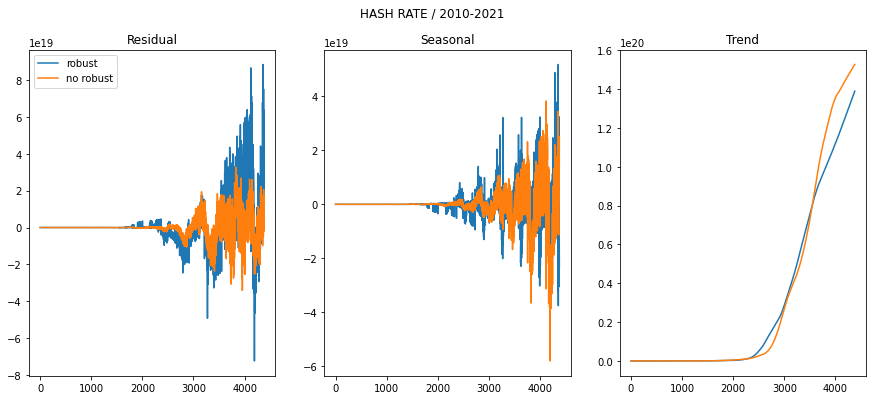

In [21]:
plt.rc("figure", figsize=(16, 16))
res1 = STL(hash_rate["Value"], period=365, robust=True).fit()
res2 = STL(hash_rate["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('HASH RATE / 2010-2021 ')

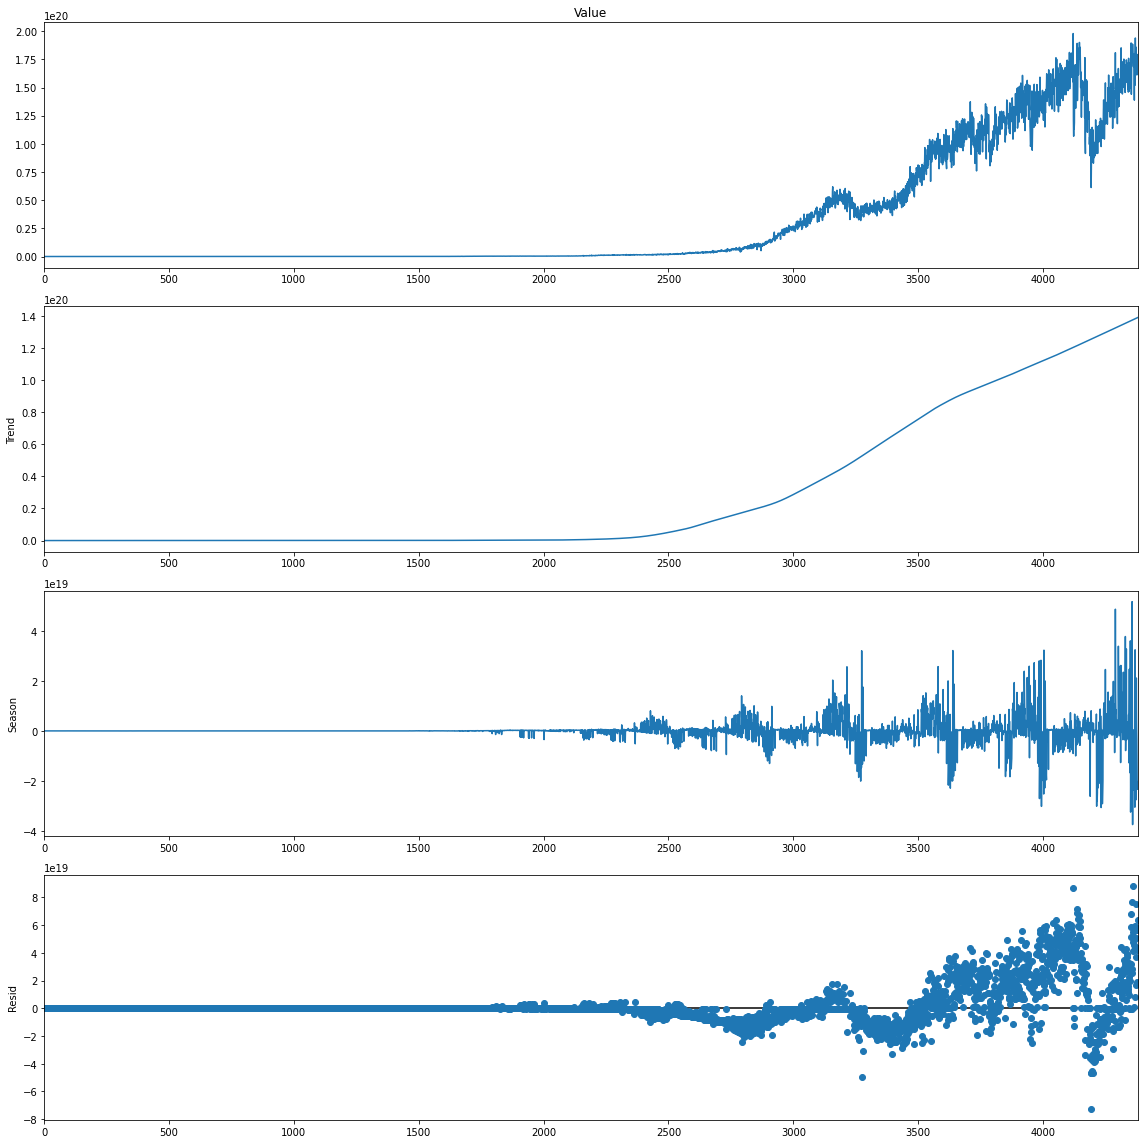

In [22]:
fig = res1.plot() #BIGGER VIEW

Text(0.5, 0.98, 'HASH RATE / 2017-2021 ')

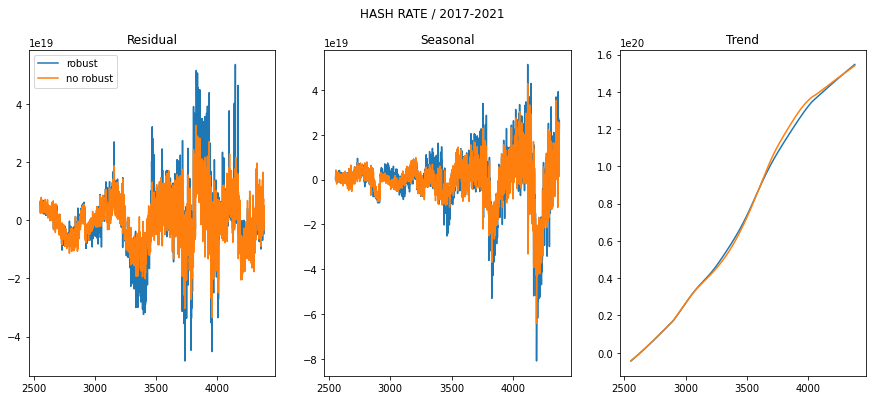

In [23]:
plt.rc("figure", figsize=(16, 16))
res3 = STL(hashh["Value"], period=365, robust=True).fit()
res4 = STL(hashh["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')


fig.suptitle('HASH RATE / 2017-2021 ')

#### Trend interpolation
We now try to interploate the trend with an exponential function.

In [24]:
#CI SONO DEI NULL VALUES DENTRO IL TREND. HO TROVATO QUESTA TECNICA

np.log(res3.trend)

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


2554          NaN
2555          NaN
2556          NaN
2557          NaN
2558          NaN
          ...    
4375    46.486403
4376    46.486756
4377    46.487108
4378    46.487459
4379    46.487811
Name: trend, Length: 1826, dtype: float64

In [25]:
# y = a*exp(bx) --> log(y) = log(a)+bx
idx = np.isfinite(np.arange(len(hashh))) & np.isfinite(np.log(res3.trend))
coefs = np.polyfit(np.arange(len(hashh))[idx]+1, np.log(res3.trend)[idx],1)
coefs
# y = exp(coefs[1])*exp(coefs[0]*x)

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([2.00008432e-03, 4.35012235e+01])

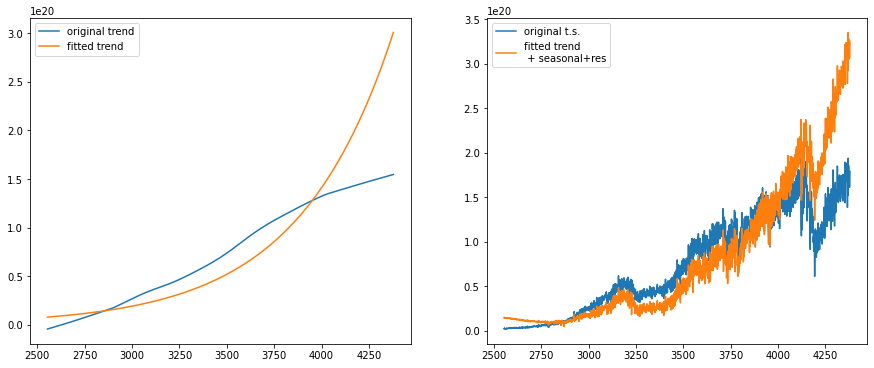

In [26]:
fitted = pd.Series(np.exp(coefs[1])*np.exp(coefs[0]*(np.arange(len(hashh))+1)), index = hashh.index)
#fitted.plot()
#res3.trend.plot()


fitted_season = fitted+res3.seasonal # fitted trend + seasonal decomposed series (orange) non so se ha senso calcolarlo
fitted_compl = fitted_season+res3.resid # fitted trend + seasonal decomposed series + residual decomposed series (green)
#hashh["Value"].plot()
#fitted_season.plot()
#fitted_compl.plot()


fig, axs = plt.subplots(ncols=2, figsize=(15,6))
axs[0].plot(res3.trend, label="original trend")
axs[0].plot(fitted, label="fitted trend")
axs[0].legend()
axs[1].plot(hashh["Value"], label='original t.s.')
#axs[1].plot(fitted_season, label='fitted trend\n + seasonal')
axs[1].plot(fitted_compl, label='fitted trend\n + seasonal+res')
axs[1].legend()

# TRAIN/VAL/TEST SPLIT

In [27]:
series = hash_rate['Value']

# Create train data set
train_split_date = '2020-12-31'
train_split_index = np.where(hash_rate.Timestamp == train_split_date)[0][0]
x_train = hash_rate.loc[hash_rate['Timestamp'] <= train_split_date]['Value']

# Create test data set
test_split_date = '2021-06-29'
test_split_index = np.where(hash_rate.Timestamp == test_split_date)[0][0]
x_test = hash_rate.loc[hash_rate['Timestamp'] >= test_split_date]['Value']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = hash_rate.loc[(hash_rate['Timestamp'] < test_split_date) & (hash_rate['Timestamp'] > train_split_date)]['Value']

Train set ranging from 2010-01-01 to 2021-01-02 00:00:00 - Number of days = 4015
Validation set ranging from 2021-01-01 00:00:00 to 2021-06-28 00:00:00 - Number of days = 180
Test set ranging from 2021-06-29 00:00:00 to 2021-12-31 00:00:00 - Number of days = 185


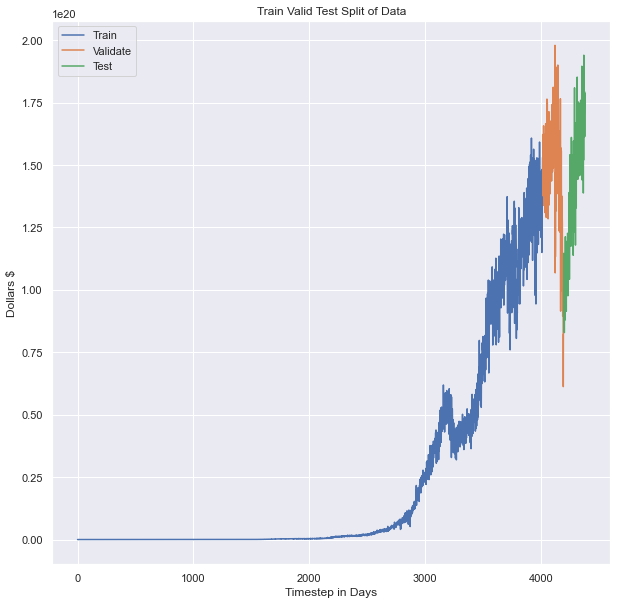

In [28]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()
#print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())
print("Train set ranging from 2010-01-01 to", hash_rate.iloc[4017]["Timestamp"], "- Number of days =", len(x_train.index))
print("Validation set ranging from", hash_rate.iloc[x_valid.index.min()]["Timestamp"], "to", hash_rate.iloc[x_valid.index.max()]["Timestamp"], "- Number of days =", len(x_valid.index))
print("Test set ranging from", hash_rate.iloc[x_test.index.min()]["Timestamp"], "to", hash_rate.iloc[x_test.index.max()]["Timestamp"], "- Number of days =", len(x_test.index))

In [29]:
len(x_train.index)

4015

In [30]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting

A naive forecast is naive because it takes the price from the day before and uses that price for the prediction of tomorrow. This is suprisingly effecting in this scenario due to the relatively due to autocorrelation. The price of tomorrow is dependent on the price today. Tomorrow's market open price is very close to the price of today's close.


Text(0.5, 1.0, 'Hash rate')

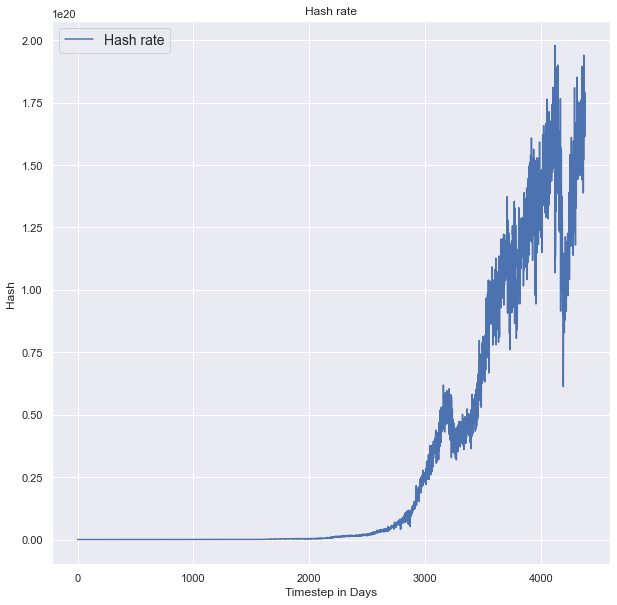

In [31]:
# Plot chart with all details untouched
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """[Plot the series data over a time range]
    Args:
        time (data range): [The entire time span of the data in range format]
        series ([integers]): [Series value corresponding to its point on the time axis]
        format (str, optional): [Graph type]. Defaults to "-".
        start (int, optional): [Time to start time series data]. Defaults to 0.
        end ([type], optional): [Where to stop time data]. Defaults to None.
        label ([str], optional): [Label name of series]. Defaults to None.
    """
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
plot_series(time=hash_rate.index,series=hash_rate['Value'], label = 'Hash rate')
plt.ylabel('Hash ')
plt.xlabel('Timestep in Days')
plt.title('Hash rate')

In [32]:
naive_forecast = series[test_split_index-1 :-1]

Text(0.5, 1.0, 'Hash rate Forecast vs Actual')

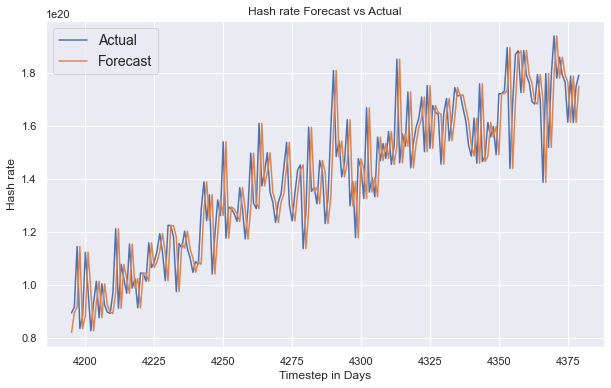

In [33]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, naive_forecast, label="Forecast")
plt.ylabel('Hash rate')
plt.xlabel('Timestep in Days')
plt.title('Hash rate Forecast vs Actual')

## Calculate Error in Naive Model

In [34]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = mean_absolute_error(x_test, naive_forecast)
model_mae_scores['naive'] = naive_forecast_mae

# view the dictionary of mae scores
model_mae_scores

{'naive': 1.3025434603123286e+19}

In [35]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_test.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_test[:3].values))

[8.22182485e+19 8.96061230e+19 9.18138595e+19]
[8.96061230e+19 9.18138595e+19 1.14608809e+20]
****************************************************************************************************
[7.38787451e+18 2.20773642e+18 2.27949499e+19]


ADESSO VADO A CREARE 2 MODELLI: 20 DAY E 5 DAY MOVING AVERAGE. MOTIVO SARA' ANCHE SPIEGATO NELLE CELLE SEGUENTI, TUTTAVIA FACCIO UNA PRECISAZIONE
- IL MODELLO 5MA SERVE A MODELLARE I 5 GIORNI DELLA SETTIMANA, IN QUANTO LA BORSA E' APERTA DA LUNEDI' A VENERDI', MENTRE GLI ALTRI GIORNI CHIUDE. 
- IL MODELLO 20MA E' COME IL PRECEDENTE, PERO' MENSILE, QUINDI MODELLA I 20 GIORNI IN CUI LA BORSA E' APERTA IN UN MESE.

TUTTO QUESTO NON VALE PER BITCOIN E CRYPTO, IN QUANTO E' SEMPRE POSSIBILE TRADARLI, OGNI ISTANTE.
IN OGNI CASO CI STA FARE QUESTA ANALISI, IN QUANTO MAGARI LA BORSA POTREBBE INFLUENZARE ANCHE LE CRYPTO

# Monthly Moving Average Model (20 Day MA)

Moving Averages are not true prediction models, however it is an important topic to demonstrate. When you hear someone talk about how they want to "de-trend" or "smooth" data they are usually talking about implementing some sort of moving average. There are multiple moving average types with the most common being simple and exponential. Simple is just the average price over the desired time span. Exponential is a little more complicated as it provides a weight factor to each time step in the window. The weights are applied to make the more recent time steps more important that the later time steps. This allows the moving average to respond much more quickly to abrupt changes.

Text(0.5, 1.0, 'SMA20 vs Actual')

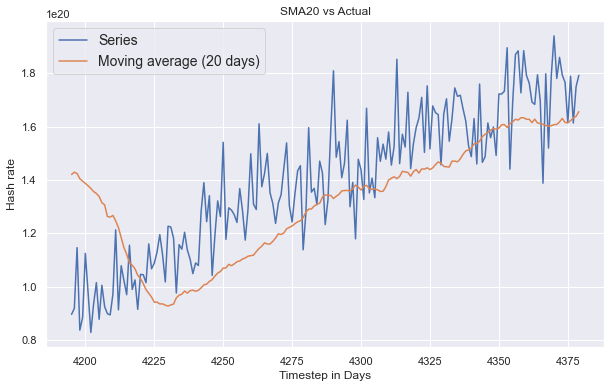

In [36]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = hash_rate['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:hash_rate.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (20 days)")
plt.ylabel('Hash rate')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')


In [37]:
ma_20 = mean_absolute_error(x_test, moving_avg_forecast)

model_mae_scores['SMA 20'] = ma_20
model_mae_scores

{'naive': 1.3025434603123286e+19, 'SMA 20': 1.7718263902870979e+19}

# Weekly Moving Average (5 day MA)

I have modeled a 20 day moving average and a 5 day moving average. This is because there are only 5 trading days a week which means 20 trading in a month. So these two moving averages show the weekly trend and the monthly trends of the S&P500. These moving averages are typically used to generate trading signals. For example, if the 5 SMA overtakes the 20 SMA that means the price is in a recent up trend and you may want to play that momentum going forward.

Text(0.5, 1.0, 'SMA5 Forecast vs Actual')

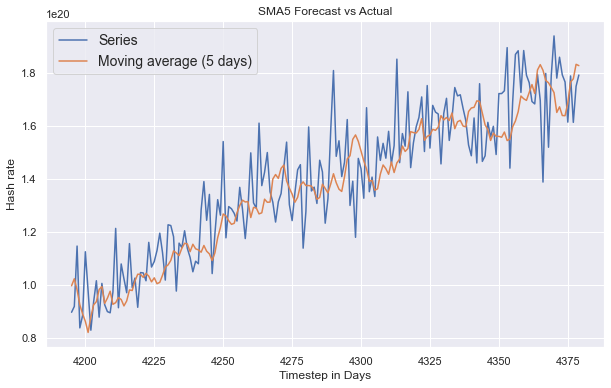

In [38]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = hash_rate['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:hash_rate.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (5 days)")
plt.ylabel('Hash rate')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

In [39]:
# Calculate MAE
ma_5 = mean_absolute_error(x_test, moving_avg_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_mae_scores

{'naive': 1.3025434603123286e+19,
 'SMA 20': 1.7718263902870979e+19,
 'SMA 5': 1.0343140678209952e+19}

# ARIMA

Step 1: Is the data stationary?
Use Augmented Dickey Fuller test to determine if the data is stationary

- Failure to reject the null hypothesis means the data is not stationary

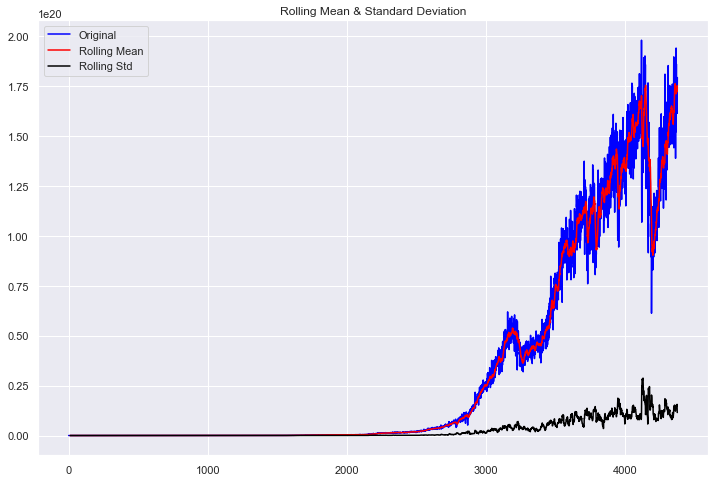

Results of Dickey-Fuller Test:
p-value = 0.9989. The series is likely non-stationary.
Test Statistic                    2.254481
p-value                           0.998924
#Lags Used                       19.000000
Number of Observations Used    4360.000000
Critical Value (1%)              -3.431851
Critical Value (5%)              -2.862203
Critical Value (10%)             -2.567123
dtype: float64


In [40]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
test_stationarity(series)


The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary. Since our data is not stationary

# Step 2 Differencing

We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference. This difference is also the calculated return over that period. Since our time steps are in days this differencing is the daily return.

In [41]:
# Get the difference of each Adj Close point
hash_rate_diff_1 = series.diff()
hash_rate_diff_1.dropna(inplace=True)

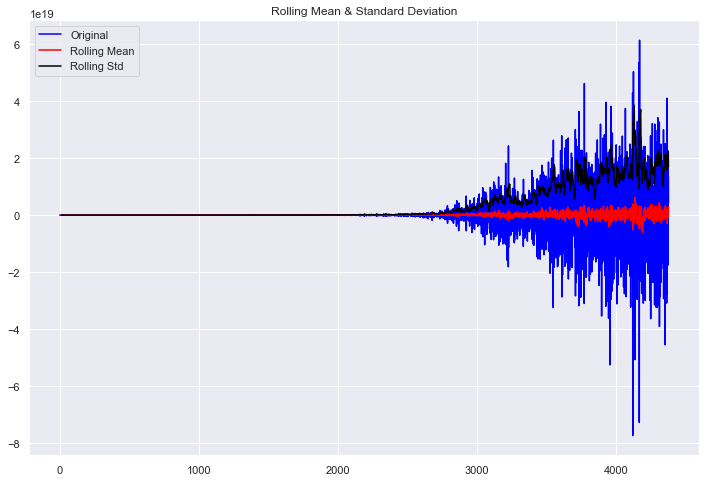

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.858663e+01
p-value                        2.075410e-30
#Lags Used                     1.800000e+01
Number of Observations Used    4.360000e+03
Critical Value (1%)           -3.431851e+00
Critical Value (5%)           -2.862203e+00
Critical Value (10%)          -2.567123e+00
dtype: float64


In [42]:
# Plot the tsla Adj Close 1st order difference
test_stationarity(hash_rate_diff_1)

The p-value is obtained is less than significance level of 0.05 and the ADF statistic is lower than any of the critical values.

We reject the null hypothesis. So, the time series is in fact stationary.

# Step 3: Autocorrelation and Partial autocorrelation
Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

Autocorrelation is the correlation between points at time t (Pₜ) and the point at(Pₜ₋₁). Partial autocorrelation is the point at time t (Pₜ) and the point (Pₜ₋ₖ) where k is any number of lags. Partial autocorrelation ignores all of the data in between both points.

In terms of a movie theater’s ticket sales, autocorrelation determines the relationship of today’s ticket sales and yesterday’s ticket sales. In comparison, partial autocorrelation defines the relationship of this Friday’s ticket sales and last Friday’s ticket sales.

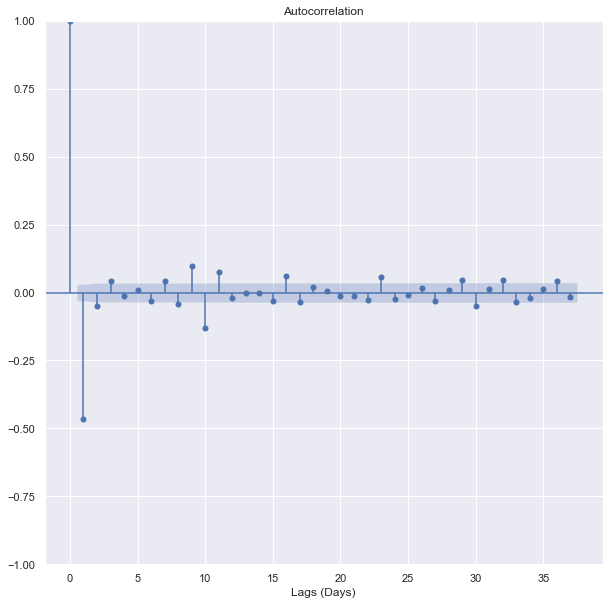

In [43]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(hash_rate_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


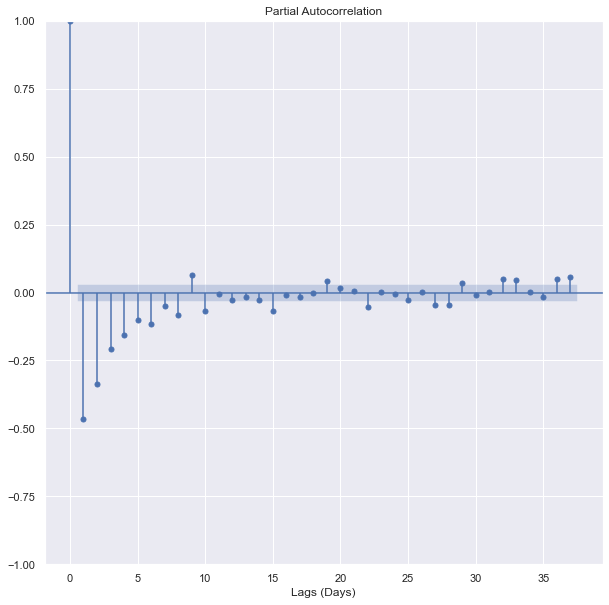

In [44]:
plot_pacf(hash_rate_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

- Let’s start with the Autocorrelation plot. The important detail of these plots is the first lag. If the first lag is positive, we use an autoregressive (AR) model, and if the first lag is negative, we use a moving average (MA) plot. Since the first lag is negative, we will use the 1st lag as a moving average point.

- For the PACF plot, at lag one, which is negatively correlated, we will use an AR factor of 1 as well. If you have trouble determining how what lags are the best to use, feel free to experiment, and watch the AIC. The lower the AIC, the better.

- The ARIMA model takes three main inputs into the “order” argument. Those arguments are ‘p’ for the AR term, ‘d’ for the differencing term, ‘q’ for the MA term.

### Testing different arima models

------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=355353.505, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=357297.854, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=356181.514, Time=0.53 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=355351.628, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=357296.074, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=355361.097, Time=0.35 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=355353.457, Time=0.94 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=355353.404, Time=1.86 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=355351.493, Time=0.88 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=355353.442, Time=1.71 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=355355.450, Time=2.78 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=357279.667, Time=0.31 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=355353.358, Time=1.11 sec
 ARIMA(0,1,2)(1,0,0)[7] inter

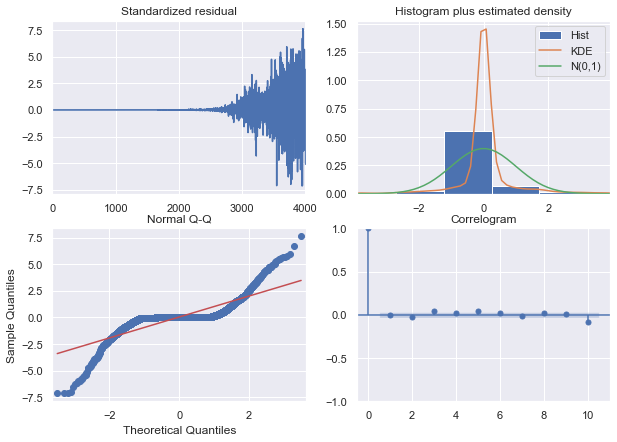

In [45]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(x_train, exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = input_seasonality, 
                          start_P = 0, seasonal = seasonal_flag, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = True, 
                          max_order=12)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_manual_sarima(y, order, seasonal_order):
    
    # Train model
    model = SARIMAX(y, order = order, seasonal_order = seasonal_order).fit()
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model

    
# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'


input_seasonality = 7


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
# Get actual values
actuals = x_test.reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))

elif input_ts_algo == 'manual_sarima':
    input_order = (3,1,0)
    input_seasonal_order = (2,1,1,7)
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = x_train, order = input_order, seasonal_order = input_seasonal_order)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = x_train)


Abbiamo trovato che il miglior modello è ARIMA(3,1,3)(1,0,0)[7]. Quindi ancora devo studiare la seasonality per capire se trovo qualche valore migliore, e in caso aggiungere sotto.

In [46]:
import statsmodels.api as sm

# fit model
hash_arima = sm.tsa.arima.ARIMA(x_train, order=(3,1,3), seasonal_order=(1,0,0,7))
hash_arima_fit = hash_arima.fit()
print(hash_arima_fit.summary())

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                     
Dep. Variable:                            Value   No. Observations:                 4015
Model:             ARIMA(3, 1, 3)x(1, 0, [], 7)   Log Likelihood             -177626.326
Date:                          Tue, 25 Oct 2022   AIC                         355268.651
Time:                                  17:55:29   BIC                         355319.032
Sample:                                       0   HQIC                        355286.507
                                         - 4015                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6416      0.011   -147.845      0.000      -1.663      -1.620
ar.L2         -0.7714      0.017    -45.012      0.

NormaltestResult(statistic=882.6309946937442, pvalue=2.18330658112613e-192)
This distribution is not a normal distribution


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


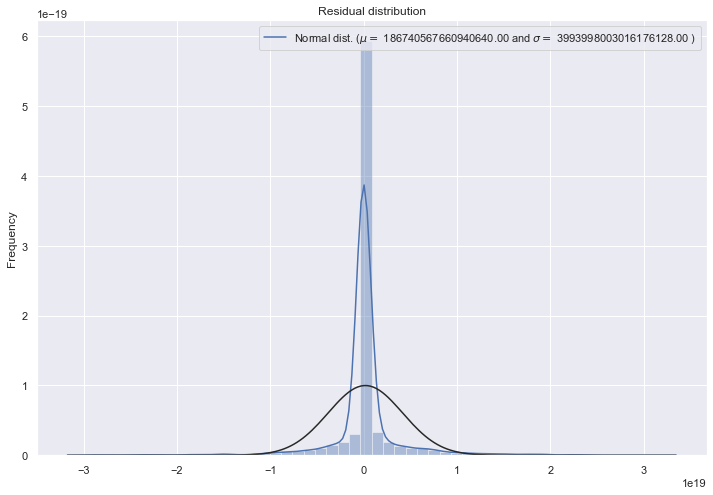

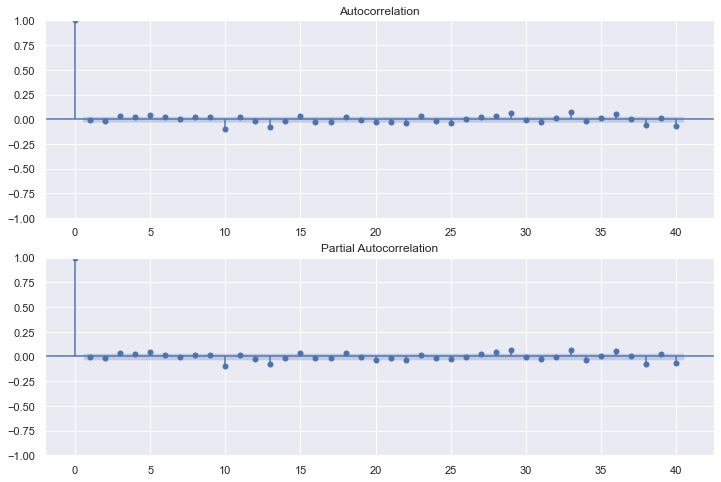

In [47]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = hash_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

# Step 4: Building the Arima Model and Forecasting
Now that we have experimented and found our prefered model order of (3,1,1)(1,0,0,7) lets build the model and get some forecasts.

This cell takes a while to run. Be careful. We have stored the model predictions using a magic method so we do not have to re-run this time consuming cell everytime.

Ci mette parecchio a calcolare questa cella giù. Se si vuole risparmiare tempo allora bisogna abbassare il numero di data points da predire

### Primo tipo di ARIMA: training ricorsivo true: train, predico 1 giorno, appendo la predizione, re-traino e così via


In [48]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#in questo modo prendo oggi, prevedo domani, appendo la previsione al trainset, retraino, predico ancora. 
#Questo è recursive learning, o autoregressive learning
# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,3), seasonal_order=(1,0,0,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    #history.append(true_test_value)
    history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

output

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_recursive_training'] = arima_mae
model_mae_scores

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

Testing Mean Squared Error is 2.3106332772341592e+19
Stored 'model_predictions' (list)


{'naive': 1.3025434603123286e+19,
 'SMA 20': 1.7718263902870979e+19,
 'SMA 5': 1.0343140678209952e+19,
 'ARIMA_recursive_training': 2.3106332772341592e+19}

- You may want to zoom in on the plot below to get a better view of the differences. To do this simply use the [:] slicing on x_test.index and model_predictions/x_test in the plt.plot() lines. I typically like to do [-100:] to get the last 100 values

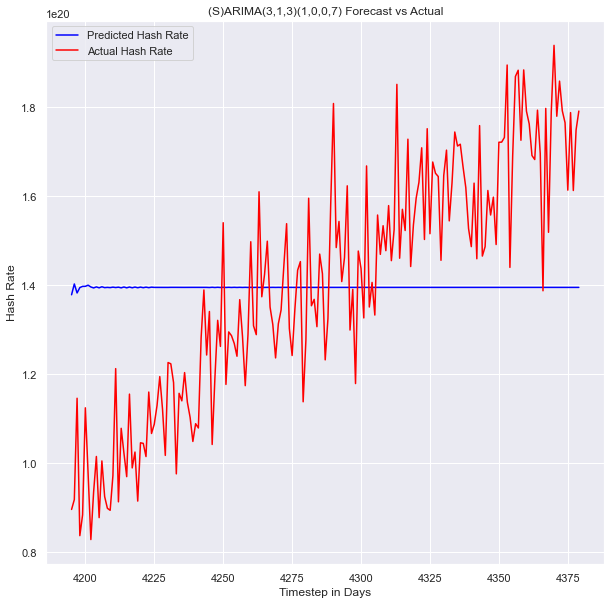

<Figure size 720x432 with 0 Axes>

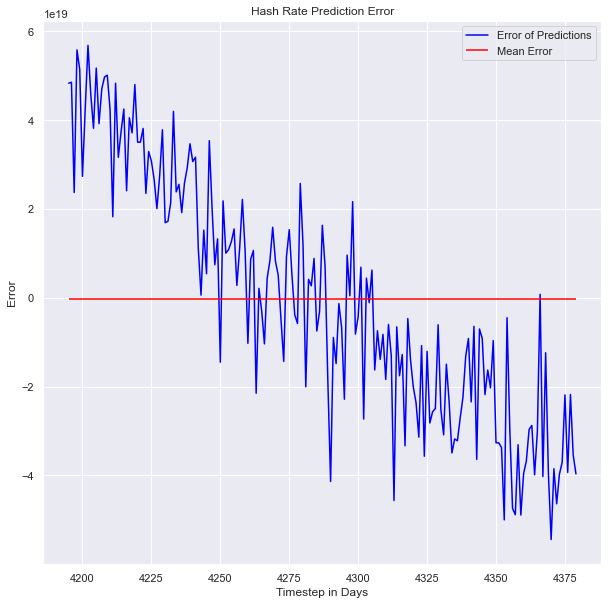

<Figure size 720x432 with 0 Axes>

{'naive': 1.3025434603123286e+19,
 'SMA 20': 1.7718263902870979e+19,
 'SMA 5': 1.0343140678209952e+19,
 'ARIMA_recursive_training': 2.3106332772341592e+19}

In [49]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Hash Rate')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual Hash Rate')
plt.ylabel('Hash Rate')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(1,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Hash Rate Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

### Secondo tipo di ARIMA: predizione ricorsiva fake: train, predico, aggiungo al trainset il primo valore VERO del test set e ricomincio (quindi sarebbe una predizione di un giorno, visto che appendo il valore vero del test set)

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

Testing Mean Squared Error is 2.3209964526931714e+19
Stored 'model_predictions' (list)


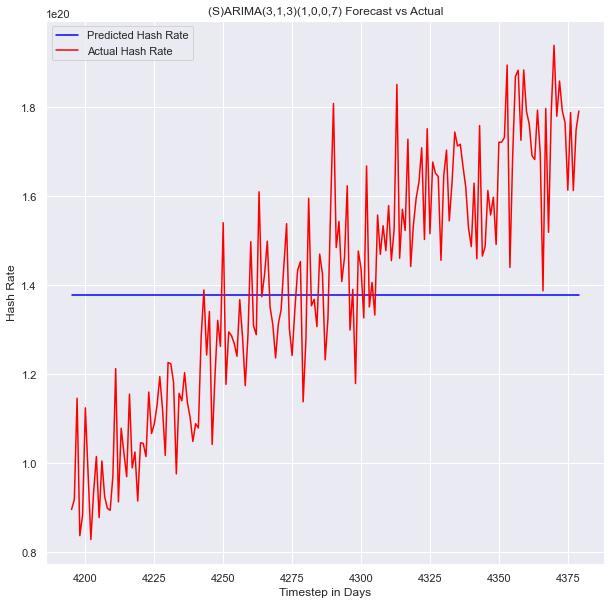

<Figure size 720x432 with 0 Axes>

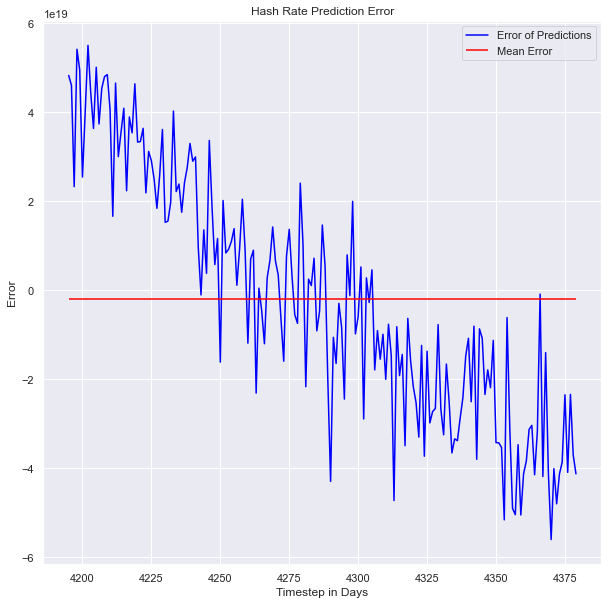

<Figure size 720x432 with 0 Axes>

{'naive': 1.3025434603123286e+19,
 'SMA 20': 1.7718263902870979e+19,
 'SMA 5': 1.0343140678209952e+19,
 'ARIMA_recursive_training': 2.3106332772341592e+19,
 'ARIMA_recursive_fake': 2.3209964526931714e+19}

In [50]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,3), seasonal_order=(1,0,0,7))
    model_fit = model.fit()

for time_point in list(x_test.index[-N_test_observations:]):
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
    #history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_recursive_fake'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Hash Rate')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual Hash Rate')
plt.ylabel('Hash Rate')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(1,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Hash Rate Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

### Terzo tipo di ARIMA: predizione ricorsiva true: train, predico, aggiungo al trainset il primo valore PREDETTO del test set e ricomincio

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

Testing Mean Squared Error is 2.3209964526931714e+19
Stored 'model_predictions' (list)


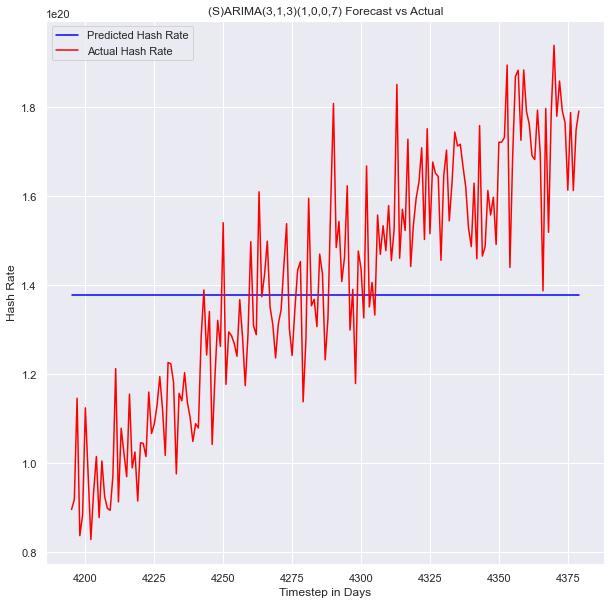

<Figure size 720x432 with 0 Axes>

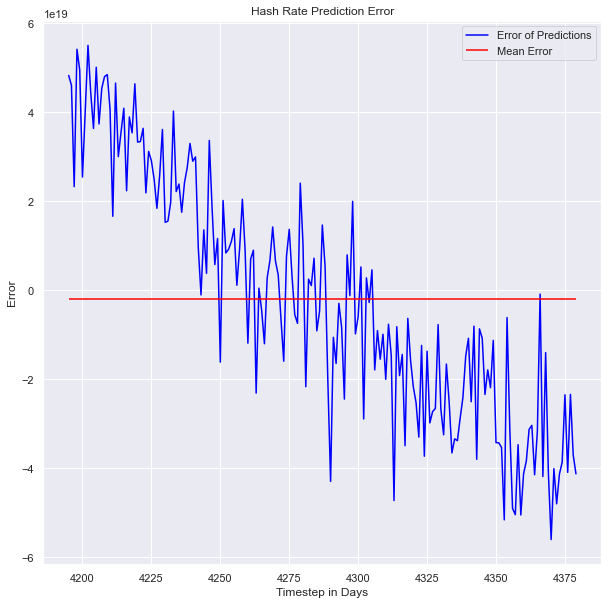

<Figure size 720x432 with 0 Axes>

{'naive': 1.3025434603123286e+19,
 'SMA 20': 1.7718263902870979e+19,
 'SMA 5': 1.0343140678209952e+19,
 'ARIMA_recursive_training': 2.3106332772341592e+19,
 'ARIMA_recursive_fake': 2.3209964526931714e+19,
 'ARIMA_recursive_true': 2.3209964526931714e+19}

In [51]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,3), seasonal_order=(1,0,0,7))
    model_fit = model.fit()

for time_point in list(x_test.index[-N_test_observations:]):
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    #history.append(true_test_value)
    history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_recursive_true'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Hash Rate')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual Hash Rate')
plt.ylabel('Hash Rate')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(1,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Hash Rate Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

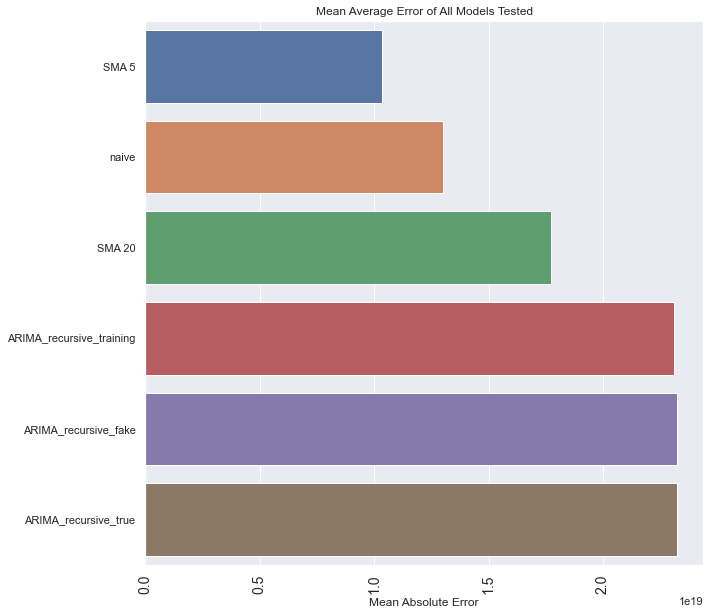

In [52]:
# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

# LSTM

- LSTM stands for Long Short Term Memory
The LSTM cell contains an RNN cell inside (dense layer with a tanh activation function), but it has other attributes that allow it to remember patterns over a longer period of time. The LSTM contains a short-term state vector that is used from one time step to the next identical to the RNN cell.

Where LSTM cells differ is their Long-Term State vector. This long term state vector undergoes a multipicative and additive operation at each time step.The long term state vector starts off with a "forget gate" which is simply a sigmoid activation on top of a dense layer which produces an output from 0 - 1. This means if the forget gate ourputs a value of 1 then the long term state vector remains unchanged. On the opposite end, if the output valuse of the dense layer is 0 the long term state vector is nullified. This helps adjust quickly to highly volatile environments. If we are in a steady uptrend and then we suddenly have a big drop in the market, the long term state vector will be erased so the model can readjust quickly.

The next gate is the input gate. The input gate is much like the forget gate, except it decides if the short term state vector gets added to the long term vector or is erased.

The last gate called the "output gate" decides what the next hidden state should be. It is important to know that this hidden state output is the prediction for the next time step. Here, the previous hidden state (previous cell output) amd current input are jammed together through sigmoid function. Then we take our newly modified long term state vector which has already passed through the forget and input gates, and apply a tanh function to it. Finally, multiple both the tanh output (long term state vector output) and the sigmoid function output (previous hidden state and new input at this time step) to what information the hidden state needs to carry to the next time step.

</br> To review, the Forget gate decides what is relevant to keep from prior steps. The input gate decides what information is relevant to add from the current step. The output gate determines what the next hidden state should be.

In [53]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [54]:
x_train

0       8.556045e+06
1       7.715468e+06
2       1.249801e+07
3       1.062697e+07
4       1.160149e+07
            ...     
4010    1.273530e+20
4011    1.365275e+20
4012    1.482739e+20
4013    1.404403e+20
4014    1.530110e+20
Name: Value, Length: 4015, dtype: float64

In [55]:
x_train.shape

(4015,)

In [56]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [57]:
x_train_values

array([[8.55604479e+06],
       [7.71546770e+06],
       [1.24980120e+07],
       ...,
       [1.48273901e+20],
       [1.40440271e+20],
       [1.53010995e+20]])

In [58]:
x_train_values.shape

(4015, 1)

In [59]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

### Find the learning rate

In [60]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


200/200 [==============================] - 8s 14ms/step - loss: 0.0048 - mae: 0.0483 - lr: 1.0000e-05
Epoch 2/100
200/200 [==============================] - 2s 12ms/step - loss: 0.0025 - mae: 0.0651 - lr: 1.1220e-05
Epoch 3/100
200/200 [==============================] - 3s 12ms/step - loss: 0.0011 - mae: 0.0401 - lr: 1.2589e-05
Epoch 4/100
200/200 [==============================] - 2s 12ms/step - loss: 4.5997e-04 - mae: 0.0207 - lr: 1.4125e-05
Epoch 5/100
200/200 [==============================] - 2s 12ms/step - loss: 3.7739e-04 - mae: 0.0132 - lr: 1.5849e-05
Epoch 6/100
200/200 [==============================] - 2s 11ms/step - loss: 3.7308e-04 - mae: 0.0116 - lr: 1.7783e-05
Epoch 7/100
200/200 [==============================] - 2s 11ms/step - loss: 3.7466e-04 - mae: 0.0114 - lr: 1.9953e-05
Epoch 8/100
200/200 [==============================] - 2s 12ms/step - loss: 3.7709e-04 - mae: 0.0113 - lr: 2.2387e-05
Epoch 9/100
200/200 [==============================] - 2s 12ms/step - loss: 3.80

200/200 [==============================] - 2s 12ms/step - loss: 0.0026 - mae: 0.0239 - lr: 0.0316
Epoch 72/100
200/200 [==============================] - 2s 12ms/step - loss: 0.0030 - mae: 0.0294 - lr: 0.0355
Epoch 73/100
200/200 [==============================] - 2s 12ms/step - loss: 0.0037 - mae: 0.0369 - lr: 0.0398
Epoch 74/100
200/200 [==============================] - 2s 12ms/step - loss: 0.0067 - mae: 0.0486 - lr: 0.0447
Epoch 75/100
200/200 [==============================] - 2s 12ms/step - loss: 0.0066 - mae: 0.0485 - lr: 0.0501
Epoch 76/100
200/200 [==============================] - 2s 11ms/step - loss: 0.0042 - mae: 0.0291 - lr: 0.0562
Epoch 77/100
200/200 [==============================] - 2s 12ms/step - loss: 0.0060 - mae: 0.0333 - lr: 0.0631
Epoch 78/100
200/200 [==============================] - 2s 11ms/step - loss: 0.0082 - mae: 0.0357 - lr: 0.0708
Epoch 79/100
200/200 [==============================] - 2s 12ms/step - loss: 0.0029 - mae: 0.0201 - lr: 0.0794
Epoch 80/100
2

(1e-05, 0.1, 0.0, 0.03)

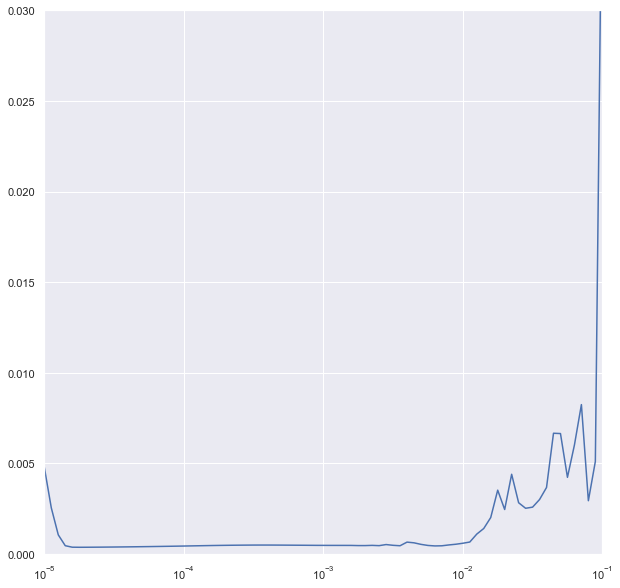

In [61]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 0.03])

In [62]:
#This is the best learning rate
history.history["loss"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00035

0.00037308144965209067

In [63]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=35e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
    132/Unknown - 7s 16ms/step - loss: 6.3953e-04 - mae: 0.0144

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 29s 178ms/step - loss: 7.0233e-04 - mae: 0.0152 - val_loss: 0.0055 - val_mae: 0.0781
Epoch 2/500
133/133 [==============================] - 2s 16ms/step - loss: 7.6423e-04 - mae: 0.0164 - val_loss: 0.0099 - val_mae: 0.1106
Epoch 3/500
133/133 [==============================] - 2s 16ms/step - loss: 5.0077e-04 - mae: 0.0132 - val_loss: 0.0124 - val_mae: 0.1280
Epoch 4/500
133/133 [==============================] - 2s 16ms/step - loss: 4.2318e-04 - mae: 0.0115 - val_loss: 0.0125 - val_mae: 0.1290
Epoch 5/500
133/133 [==============================] - 2s 16ms/step - loss: 4.2078e-04 - mae: 0.0119 - val_loss: 0.0131 - val_mae: 0.1328
Epoch 6/500
133/133 [==============================] - 2s 16ms/step - loss: 4.1743e-04 - mae: 0.0119 - val_loss: 0.0133 - val_mae: 0.1339
Epoch 7/500
133/133 [==============================] - 2s 16ms/step - loss: 4.1457e-04 - mae: 0.0119 - val_loss: 0.0136 - val_mae: 0.1360
Epoch 8/500
133/133 [=======================

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 168ms/step - loss: 3.4306e-04 - mae: 0.0101 - val_loss: 0.0054 - val_mae: 0.0761
Epoch 41/500
131/133 [============================>.] - ETA: 0s - loss: 2.6883e-04 - mae: 0.0089

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 21s 162ms/step - loss: 3.4182e-04 - mae: 0.0100 - val_loss: 0.0052 - val_mae: 0.0752
Epoch 42/500
132/133 [============================>.] - ETA: 0s - loss: 3.0619e-04 - mae: 0.0095

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 166ms/step - loss: 3.4116e-04 - mae: 0.0100 - val_loss: 0.0052 - val_mae: 0.0745
Epoch 43/500
131/133 [============================>.] - ETA: 0s - loss: 2.6835e-04 - mae: 0.0089

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 168ms/step - loss: 3.4046e-04 - mae: 0.0100 - val_loss: 0.0051 - val_mae: 0.0739
Epoch 44/500
132/133 [============================>.] - ETA: 0s - loss: 3.0565e-04 - mae: 0.0095

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 25s 188ms/step - loss: 3.3981e-04 - mae: 0.0100 - val_loss: 0.0050 - val_mae: 0.0733
Epoch 45/500
133/133 [==============================] - ETA: 0s - loss: 3.3924e-04 - mae: 0.0099

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 180ms/step - loss: 3.3924e-04 - mae: 0.0099 - val_loss: 0.0049 - val_mae: 0.0726
Epoch 46/500
131/133 [============================>.] - ETA: 0s - loss: 2.6770e-04 - mae: 0.0089

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 21s 162ms/step - loss: 3.3854e-04 - mae: 0.0099 - val_loss: 0.0048 - val_mae: 0.0720
Epoch 47/500
131/133 [============================>.] - ETA: 0s - loss: 2.6764e-04 - mae: 0.0089

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 166ms/step - loss: 3.3801e-04 - mae: 0.0099 - val_loss: 0.0048 - val_mae: 0.0714
Epoch 48/500
131/133 [============================>.] - ETA: 0s - loss: 2.6733e-04 - mae: 0.0089

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 166ms/step - loss: 3.3726e-04 - mae: 0.0099 - val_loss: 0.0047 - val_mae: 0.0709
Epoch 49/500
132/133 [============================>.] - ETA: 0s - loss: 3.0455e-04 - mae: 0.0094

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 167ms/step - loss: 3.3674e-04 - mae: 0.0099 - val_loss: 0.0046 - val_mae: 0.0704
Epoch 50/500
133/133 [==============================] - ETA: 0s - loss: 3.3603e-04 - mae: 0.0099

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 165ms/step - loss: 3.3603e-04 - mae: 0.0099 - val_loss: 0.0046 - val_mae: 0.0699
Epoch 51/500
133/133 [==============================] - ETA: 0s - loss: 3.3549e-04 - mae: 0.0099

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 167ms/step - loss: 3.3549e-04 - mae: 0.0099 - val_loss: 0.0045 - val_mae: 0.0695
Epoch 52/500
132/133 [============================>.] - ETA: 0s - loss: 3.0378e-04 - mae: 0.0094

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 166ms/step - loss: 3.3483e-04 - mae: 0.0099 - val_loss: 0.0044 - val_mae: 0.0690
Epoch 53/500
130/133 [============================>.] - ETA: 0s - loss: 2.4479e-04 - mae: 0.0084

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 168ms/step - loss: 3.3432e-04 - mae: 0.0099 - val_loss: 0.0044 - val_mae: 0.0687
Epoch 54/500
131/133 [============================>.] - ETA: 0s - loss: 2.6635e-04 - mae: 0.0088

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 166ms/step - loss: 3.3377e-04 - mae: 0.0099 - val_loss: 0.0044 - val_mae: 0.0684
Epoch 55/500
132/133 [============================>.] - ETA: 0s - loss: 3.0315e-04 - mae: 0.0094

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 166ms/step - loss: 3.3330e-04 - mae: 0.0099 - val_loss: 0.0043 - val_mae: 0.0681
Epoch 56/500
133/133 [==============================] - ETA: 0s - loss: 3.3273e-04 - mae: 0.0099

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 168ms/step - loss: 3.3273e-04 - mae: 0.0099 - val_loss: 0.0043 - val_mae: 0.0679
Epoch 57/500
133/133 [==============================] - ETA: 0s - loss: 3.3216e-04 - mae: 0.0099

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 167ms/step - loss: 3.3216e-04 - mae: 0.0099 - val_loss: 0.0042 - val_mae: 0.0676
Epoch 58/500
132/133 [============================>.] - ETA: 0s - loss: 3.0258e-04 - mae: 0.0094

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 167ms/step - loss: 3.3153e-04 - mae: 0.0099 - val_loss: 0.0042 - val_mae: 0.0674
Epoch 59/500
133/133 [==============================] - ETA: 0s - loss: 3.3093e-04 - mae: 0.0099

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 166ms/step - loss: 3.3093e-04 - mae: 0.0099 - val_loss: 0.0042 - val_mae: 0.0672
Epoch 60/500
132/133 [============================>.] - ETA: 0s - loss: 3.0211e-04 - mae: 0.0094

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 25s 192ms/step - loss: 3.3037e-04 - mae: 0.0098 - val_loss: 0.0041 - val_mae: 0.0670
Epoch 61/500
131/133 [============================>.] - ETA: 0s - loss: 2.6531e-04 - mae: 0.0088

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 23s 171ms/step - loss: 3.2987e-04 - mae: 0.0098 - val_loss: 0.0041 - val_mae: 0.0668
Epoch 62/500
133/133 [==============================] - ETA: 0s - loss: 3.2942e-04 - mae: 0.0098

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 23s 173ms/step - loss: 3.2942e-04 - mae: 0.0098 - val_loss: 0.0041 - val_mae: 0.0667
Epoch 63/500
133/133 [==============================] - ETA: 0s - loss: 3.2900e-04 - mae: 0.0098

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 166ms/step - loss: 3.2900e-04 - mae: 0.0098 - val_loss: 0.0041 - val_mae: 0.0666
Epoch 64/500
131/133 [============================>.] - ETA: 0s - loss: 2.6508e-04 - mae: 0.0088

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 166ms/step - loss: 3.2859e-04 - mae: 0.0098 - val_loss: 0.0040 - val_mae: 0.0666
Epoch 65/500
130/133 [============================>.] - ETA: 0s - loss: 2.4341e-04 - mae: 0.0084

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 167ms/step - loss: 3.2822e-04 - mae: 0.0098 - val_loss: 0.0040 - val_mae: 0.0666
Epoch 66/500
131/133 [============================>.] - ETA: 0s - loss: 2.6494e-04 - mae: 0.0088

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 163ms/step - loss: 3.2785e-04 - mae: 0.0098 - val_loss: 0.0040 - val_mae: 0.0666
Epoch 67/500
133/133 [==============================] - ETA: 0s - loss: 3.2750e-04 - mae: 0.0098

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 169ms/step - loss: 3.2750e-04 - mae: 0.0098 - val_loss: 0.0040 - val_mae: 0.0666
Epoch 68/500
131/133 [============================>.] - ETA: 0s - loss: 2.6483e-04 - mae: 0.0088

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 165ms/step - loss: 3.2716e-04 - mae: 0.0098 - val_loss: 0.0040 - val_mae: 0.0667
Epoch 69/500
132/133 [============================>.] - ETA: 0s - loss: 3.0085e-04 - mae: 0.0094

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 169ms/step - loss: 3.2683e-04 - mae: 0.0098 - val_loss: 0.0040 - val_mae: 0.0668
Epoch 70/500
131/133 [============================>.] - ETA: 0s - loss: 2.6475e-04 - mae: 0.0088

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 166ms/step - loss: 3.2652e-04 - mae: 0.0098 - val_loss: 0.0040 - val_mae: 0.0669
Epoch 71/500
130/133 [============================>.] - ETA: 0s - loss: 2.4317e-04 - mae: 0.0084

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 21s 162ms/step - loss: 3.2619e-04 - mae: 0.0098 - val_loss: 0.0040 - val_mae: 0.0670
Epoch 72/500
133/133 [==============================] - 2s 16ms/step - loss: 3.2591e-04 - mae: 0.0098 - val_loss: 0.0040 - val_mae: 0.0672
Epoch 73/500
133/133 [==============================] - 2s 16ms/step - loss: 3.2567e-04 - mae: 0.0098 - val_loss: 0.0040 - val_mae: 0.0674
Epoch 74/500
133/133 [==============================] - 2s 16ms/step - loss: 3.2538e-04 - mae: 0.0098 - val_loss: 0.0040 - val_mae: 0.0676
Epoch 75/500
133/133 [==============================] - 2s 16ms/step - loss: 3.2513e-04 - mae: 0.0098 - val_loss: 0.0040 - val_mae: 0.0678
Epoch 76/500
133/133 [==============================] - 2s 16ms/step - loss: 3.2489e-04 - mae: 0.0098 - val_loss: 0.0040 - val_mae: 0.0681
Epoch 77/500
133/133 [==============================] - 2s 16ms/step - loss: 3.2467e-04 - mae: 0.0098 - val_loss: 0.0040 - val_mae: 0.0683
Epoch 78/500
133/133 [================

### Make predictions

In [64]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

1/1 [==============================] - 1s 1s/step


(185,)

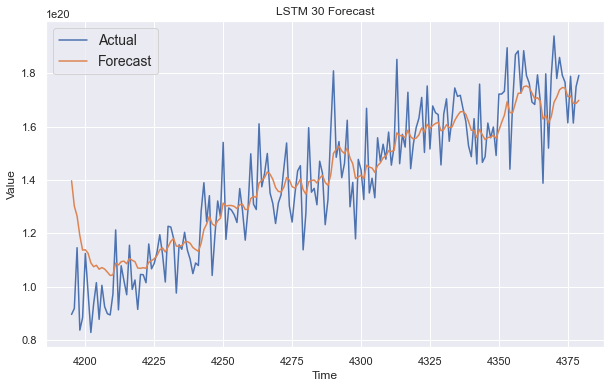

In [65]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Hash rate')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

In [66]:
# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM'] = lstm
model_mae_scores

{'naive': 1.3025434603123286e+19,
 'SMA 20': 1.7718263902870979e+19,
 'SMA 5': 1.0343140678209952e+19,
 'ARIMA_recursive_training': 2.3106332772341592e+19,
 'ARIMA_recursive_fake': 2.3209964526931714e+19,
 'ARIMA_recursive_true': 2.3209964526931714e+19,
 'LSTM': 9.046326013459043e+18}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

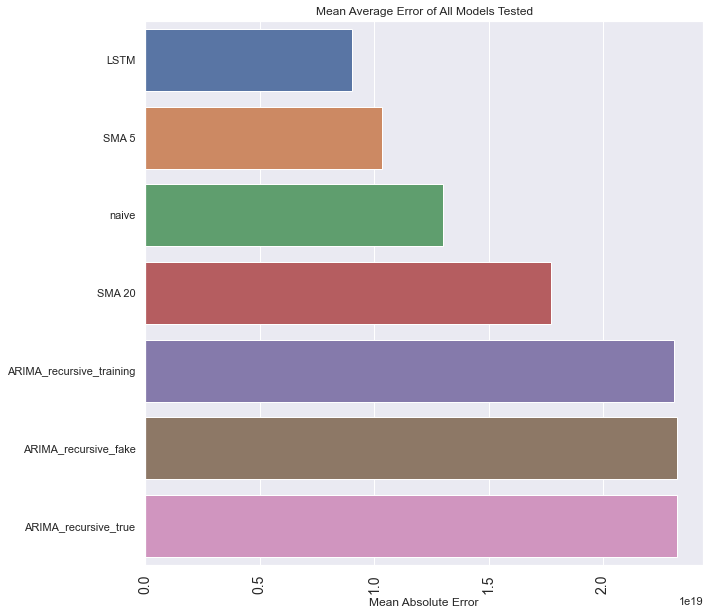

In [67]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

# CNN

Full CNNs are becoming more commom to detect trends in NLP and time series modeling. A popular architecture is the WaveNet architecture proposed by Deep Mind in 2016.

In WaveNet, every layer has kernel size 2, stride 1, causal padding, and using ReLU activation functions. However, the 2nd layer uses a dilation rate of 2. This means it skips every other input timestep. The next layer uses a dilation rate of 4 which means it skips every 3 input time steps. The fourth layer uses a dilation rate of 8 which means it skips every 7 timesteps out of 8. This patter continues which enables the lower layers to learn shorter term patterns while the deeper layers learn the longer term patterns.

The last layer acts as a dense layer to output a single value.

In [68]:
def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Find the learning rate

In [69]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


32/32 [==============================] - 5s 28ms/step - loss: 0.0331 - mae: 0.1232 - lr: 1.0000e-04
Epoch 2/100
32/32 [==============================] - 1s 28ms/step - loss: 0.0304 - mae: 0.1285 - lr: 1.0798e-04
Epoch 3/100
32/32 [==============================] - 1s 27ms/step - loss: 0.0272 - mae: 0.1295 - lr: 1.1659e-04
Epoch 4/100
32/32 [==============================] - 1s 30ms/step - loss: 0.0227 - mae: 0.1281 - lr: 1.2589e-04
Epoch 5/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0159 - mae: 0.1171 - lr: 1.3594e-04
Epoch 6/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0081 - mae: 0.0884 - lr: 1.4678e-04
Epoch 7/100
32/32 [==============================] - 1s 30ms/step - loss: 0.0044 - mae: 0.0626 - lr: 1.5849e-04
Epoch 8/100
32/32 [==============================] - 1s 27ms/step - loss: 0.0028 - mae: 0.0423 - lr: 1.7113e-04
Epoch 9/100
32/32 [==============================] - 1s 27ms/step - loss: 0.0019 - mae: 0.0298 - lr: 1.8478e-04
Epoc

32/32 [==============================] - 1s 25ms/step - loss: 0.0016 - mae: 0.0337 - lr: 0.0251
Epoch 74/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0026 - mae: 0.0456 - lr: 0.0271
Epoch 75/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0193 - mae: 0.1277 - lr: 0.0293
Epoch 76/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0667 - mae: 0.1908 - lr: 0.0316
Epoch 77/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0238 - mae: 0.1551 - lr: 0.0341
Epoch 78/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0227 - mae: 0.1507 - lr: 0.0369
Epoch 79/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0227 - mae: 0.1510 - lr: 0.0398
Epoch 80/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0237 - mae: 0.1549 - lr: 0.0430
Epoch 81/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0223 - mae: 0.1500 - lr: 0.0464
Epoch 82/100
32/32 [============

(0.0001, 0.1, 0.0, 0.04)

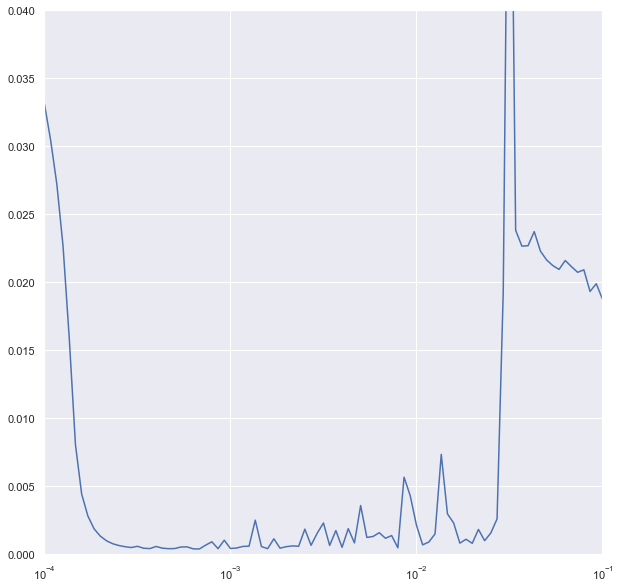

In [70]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .04])

In [71]:
#This is the best learning rate
history.history["loss"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00035 anche qui

0.0003741238615475595

In [72]:
# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 30
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=35e-5)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
32/32 [==============================] - 8s 148ms/step - loss: 0.0052 - mae: 0.0537 - val_loss: 0.0200 - val_mae: 0.1395
Epoch 2/500
32/32 [==============================] - 4s 114ms/step - loss: 0.0018 - mae: 0.0336 - val_loss: 0.0094 - val_mae: 0.1003
Epoch 3/500
32/32 [==============================] - 4s 114ms/step - loss: 4.8500e-04 - mae: 0.0162 - val_loss: 0.0063 - val_mae: 0.0849
Epoch 4/500
32/32 [==============================] - 4s 115ms/step - loss: 4.1988e-04 - mae: 0.0140 - val_loss: 0.0109 - val_mae: 0.1279
Epoch 5/500
32/32 [==============================] - 4s 110ms/step - loss: 3.9504e-04 - mae: 0.0132 - val_loss: 0.0116 - val_mae: 0.1325
Epoch 6/500
32/32 [==============================] - 4s 118ms/step - loss: 4.5046e-04 - mae: 0.0138 - val_loss: 0.0169 - val_mae: 0.1652
Epoch 7/500
32/32 [==============================] - 4s 112ms/step - loss: 3.9108e-04 - mae: 0.0135 - val_loss: 0.0053 - val_mae: 0.0779
Epoch 8/500
32/32 [==============================

32/32 [==============================] - 4s 108ms/step - loss: 4.0017e-04 - mae: 0.0126 - val_loss: 0.0075 - val_mae: 0.0916
Epoch 61/500
32/32 [==============================] - 4s 110ms/step - loss: 3.5868e-04 - mae: 0.0118 - val_loss: 0.0056 - val_mae: 0.0816
Epoch 62/500
32/32 [==============================] - 4s 108ms/step - loss: 3.4531e-04 - mae: 0.0107 - val_loss: 0.0078 - val_mae: 0.1045
Epoch 63/500
32/32 [==============================] - 4s 106ms/step - loss: 3.3848e-04 - mae: 0.0113 - val_loss: 0.0053 - val_mae: 0.0764
Epoch 64/500
32/32 [==============================] - 4s 111ms/step - loss: 3.2365e-04 - mae: 0.0104 - val_loss: 0.0052 - val_mae: 0.0759
Epoch 65/500
32/32 [==============================] - 4s 108ms/step - loss: 3.1965e-04 - mae: 0.0105 - val_loss: 0.0056 - val_mae: 0.0779
Epoch 66/500
32/32 [==============================] - 4s 108ms/step - loss: 3.9297e-04 - mae: 0.0118 - val_loss: 0.0461 - val_mae: 0.2832
Epoch 67/500
32/32 [===========================

32/32 [==============================] - 4s 108ms/step - loss: 3.0255e-04 - mae: 0.0099 - val_loss: 0.0059 - val_mae: 0.0880
Epoch 120/500
32/32 [==============================] - 4s 110ms/step - loss: 3.0846e-04 - mae: 0.0105 - val_loss: 0.0059 - val_mae: 0.0878
Epoch 121/500
32/32 [==============================] - 4s 107ms/step - loss: 3.2398e-04 - mae: 0.0107 - val_loss: 0.0091 - val_mae: 0.1148
Epoch 122/500
32/32 [==============================] - 4s 109ms/step - loss: 3.7747e-04 - mae: 0.0128 - val_loss: 0.0125 - val_mae: 0.1290
Epoch 123/500
32/32 [==============================] - 4s 108ms/step - loss: 4.5779e-04 - mae: 0.0140 - val_loss: 0.0052 - val_mae: 0.0797
Epoch 124/500
32/32 [==============================] - 4s 107ms/step - loss: 3.1544e-04 - mae: 0.0110 - val_loss: 0.0053 - val_mae: 0.0807
Epoch 125/500
32/32 [==============================] - 4s 109ms/step - loss: 3.0230e-04 - mae: 0.0102 - val_loss: 0.0055 - val_mae: 0.0829
Epoch 126/500
32/32 [====================

32/32 [==============================] - 4s 109ms/step - loss: 3.8994e-04 - mae: 0.0119 - val_loss: 0.0059 - val_mae: 0.0807
Epoch 179/500
32/32 [==============================] - 4s 107ms/step - loss: 3.3329e-04 - mae: 0.0118 - val_loss: 0.0057 - val_mae: 0.0850
Epoch 180/500
32/32 [==============================] - 4s 108ms/step - loss: 2.8660e-04 - mae: 0.0100 - val_loss: 0.0055 - val_mae: 0.0830
Epoch 181/500
32/32 [==============================] - 4s 108ms/step - loss: 2.8940e-04 - mae: 0.0098 - val_loss: 0.0052 - val_mae: 0.0774
Epoch 182/500
32/32 [==============================] - 4s 107ms/step - loss: 2.8772e-04 - mae: 0.0100 - val_loss: 0.0058 - val_mae: 0.0864


In [73]:
# reload best model checkpoint
model = keras.models.load_model("my_checkpoint.h5")

In [74]:
# Use best model to get forecasts
cnn_forecast = model_forecast(model, spy_normalized_to_traindata[:,  np.newaxis], window_size)
cnn_forecast = cnn_forecast[x_test.index.min() - window_size:-1,-1,0]
# Scale back to normal
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

136/136 [==============================] - 2s 8ms/step


(185,)

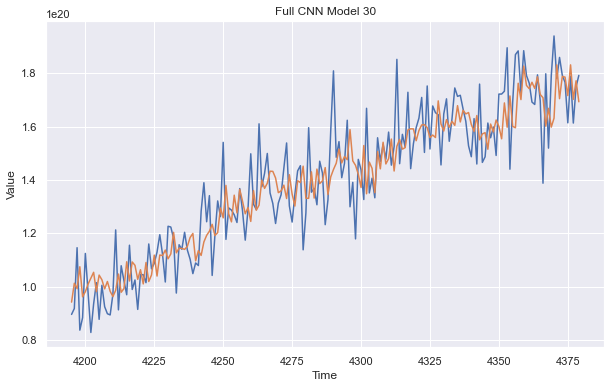

In [75]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Hash rate')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plot_series(x_test.index, x_test)
plot_series(x_test.index, cnn_unscaled_forecast)

In [76]:
# Calculate MAE
cnn = mean_absolute_error(x_test, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['CNN'] = cnn
model_mae_scores

{'naive': 1.3025434603123286e+19,
 'SMA 20': 1.7718263902870979e+19,
 'SMA 5': 1.0343140678209952e+19,
 'ARIMA_recursive_training': 2.3106332772341592e+19,
 'ARIMA_recursive_fake': 2.3209964526931714e+19,
 'ARIMA_recursive_true': 2.3209964526931714e+19,
 'LSTM': 9.046326013459043e+18,
 'CNN': 9.940720943715068e+18}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

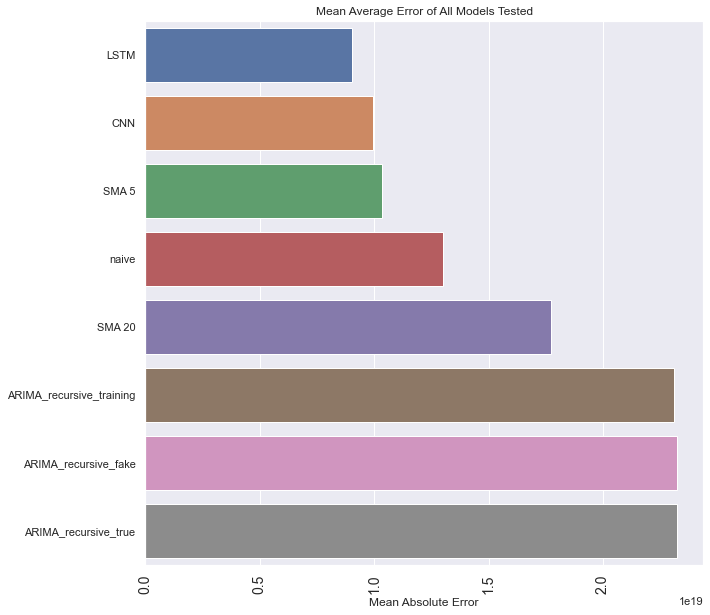

In [77]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')